In [1]:
import pandas as pd
import numpy as np
import pathlib as p
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import utils 

# if we are then let's change the parameter
# look at feat importance

master_path = p.Path.cwd()
gold_path = master_path / "gold"
data = pd.read_parquet(gold_path / "features_bikes_stations_weather.parquet")
data.hpcp_rank.fillna(0,inplace=True)
features = [
    x
    for x in data.columns.tolist()
    if x not in ["start_date", "duration"]
]
X = data[features]
y = data["duration"]

# simple train test split to have a first idea
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

#then oof set up to see if we are overfitting

# Run a baseline random forest

In [6]:
rf_clf = utils.rf_training(x_train, y_train)
y_pred = rf_clf.predict(x_test)
utils.regression_report(y_test, y_pred)

Mean Absolute Error (MAE): 284.9032098412649
Mean Squared Error (MSE): 143836.82984624253
Root Mean Squared Error (RMSE): 379.25826272639404
R^2: 0.03627968263653514


### The results aren't too promising- let's look at feat importance

In [ ]:
rf_importances = utils.compute_forest_importance(
    rf_clf, x_test, y_test, features, permutation="off"
)

### RF Feature importance is biased towards higher cardinality features. 
### Precipitation data is so low, why is that? It should have an impact

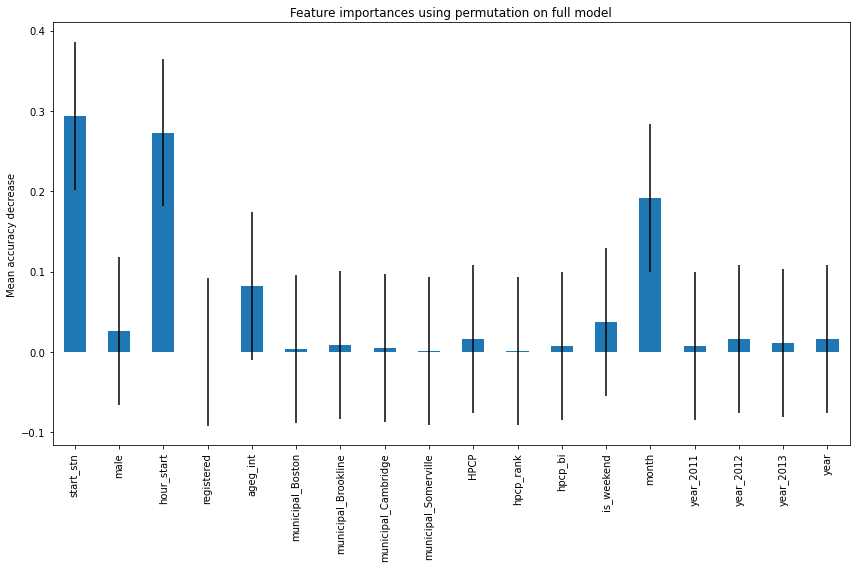

In [9]:
utils.plot_forest_importance(rf_importances)

### Permutation corrects for this effect

In [10]:
rf_importances = utils.compute_forest_importance(
    rf_clf, x_test, y_test, features, permutation="on"
)

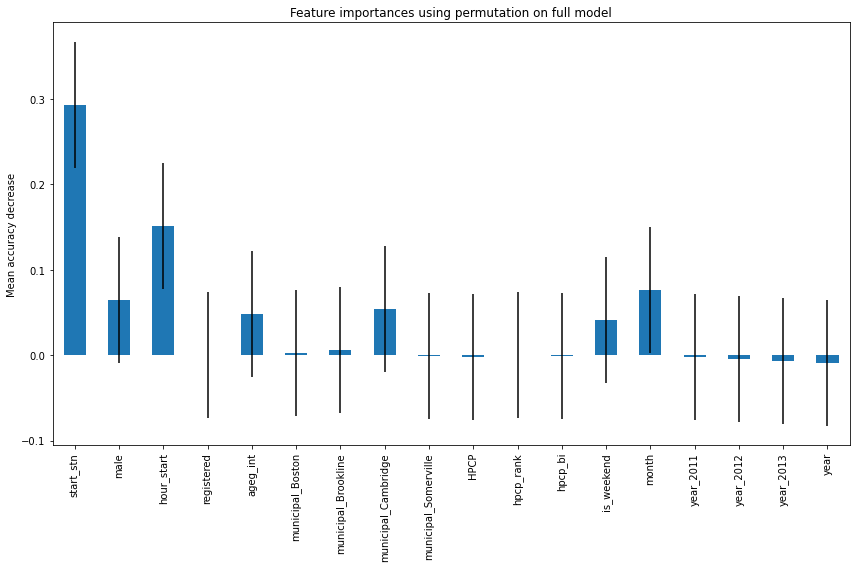

In [11]:
utils.plot_forest_importance(rf_importances)

### Remove features with very low importance, run OOF Set up for better validation

In [3]:
# could use hyperopt to do the hyperparameters tuning
# remove features that have no importance and look at OOF set up
to_drop = ['registered','hpcp_rank','hpcp_bi','year_2012','year_2011','year_2013']
# an improvement in the performance would be to fit an anova to see which feat carry more info
mean_s, std_s, scores = utils.OOF_Predictions(
    np.array(X.drop(to_drop,axis=1)),
    np.array(y),
    model=RandomForestRegressor(n_estimators=100, random_state=222),
)
########################################################

Test score >  143107.22658266066
Train score >  101116.87973669852
Test score >  143202.1458649861
Train score >  101123.42658759054
Test score >  142258.3104939792
Train score >  101311.92562954113
Test score >  143119.8864462939
Train score >  101079.64746345366
Test score >  142967.13067696165
Train score >  101237.47153334304


In [4]:
mean_s

142930.9400129763

# Run LightGBM for training and prediction

In [2]:
## LighGBM
########################################################
params = {
    "task": "train",
    "boosting": "gbdt",
    "random_state": 4590,
    "objective": "regression",
    "feature_pre_filter": "false",
    "feature_fraction": 0.6,
    "bagging_fraction": 1.0,
    "num_leaves": 50,
    "bagging_freq": 0,
    "min_child_samples": 5,
    "metric": "MSE",
}

### Validation data set needs to be created to tune LightGBM hyper-parameters

In [3]:
# simple train test split to have a first idea
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
# create validation set of 1%
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9)
# then oof set up to see if we are overfitting

c:\Users\FarinaD\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\FarinaD\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 785514, number of used features: 18
[LightGBM] [Info] Start training from score 632.521540
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 134725
Mean Absolute Error (MAE): 285.1355371701445
Mean Squared Error (MSE): 134724.71814659084
Root Mean Squared Error (RMSE): 367.0486590992955
R^2: 0.09235250800025419


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

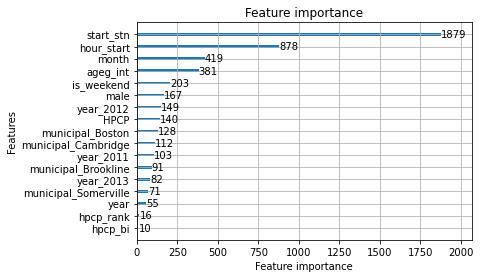

In [4]:
#########################################################
# prediction
lgb_clf = utils.lgb_training(x_train, x_test, y_train, y_test, p=params)
y_pred = lgb_clf.predict(x_test, num_iteration=lgb_clf.best_iteration)
utils.regression_report(y_test, y_pred)
# MSE is really high
# MSE: 3540887.32
# RMSE: 1881.72
# no tuning
# It is actually worse then random forest. More work needs to be done for the hyperparameters
# we could try and tune the model with optuna
#############################################
# lgb feature importance
lgb.plot_importance(lgb_clf)

### The gradient boosting model outperformed the random forest as expected. We can see the improvements in feature ranking as well. Now the age variable is much more important (not as much because it was very empty), also HPCP variable has more importance as we would expect.

### Try to drop features and see if performance improves, it shouldn't  do that much because the algorithm is good at preventing overfitting

In [5]:
to_drop = ['registered','hpcp_rank','hpcp_bi','year']
x_train, x_test, y_train, y_test = train_test_split(X.drop(to_drop,axis=1), y, train_size=0.8)
# create validation set of 1%
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9)

In [6]:
lgb_clf = utils.lgb_training(x_train, x_test, y_train, y_test, p=params)
y_pred = lgb_clf.predict(x_test, num_iteration=lgb_clf.best_iteration)
utils.regression_report(y_test, y_pred)

c:\Users\FarinaD\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\FarinaD\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 785514, number of used features: 14
[LightGBM] [Info] Start training from score 632.199971
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 134818
Mean Absolute Error (MAE): 285.2760434712117
Mean Squared Error (MSE): 134818.33354154168
Root Mean Squared Error (RMSE): 367.17616145597157
R^2: 0.09208955736996671
